<a href="https://www.kaggle.com/code/aisuko/constructing-diffusers-sd-pipeline?scriptVersionId=134889144" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Installing the dependencies

In [1]:
!pip install diffusers["torch","flax"] transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1


### Load all components

**Load all these components** with the `from_pretrained()` method. And more detail can be finded in [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5),and each component is stored in a separate subfolder:

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

model_name = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder = "text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder = "unet")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Instead of the default PNDMScheduler, exchange it for the UniPCMultistepScheduler**

In [3]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")

**To speed up inference**, move the models to a GPU instance, unlike the scheduler they have trainable weights

In [4]:
# cuda for Nvidia, mps stands for Metal Performance Shaders on Apple
torch_device="cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

# Create text embeddings

**Tokenizing** the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

In [5]:
prompt =["a photograph of an astronaut riding a horse"]
# default weight of Stable Diffusion
height = 512
width = 512
# Number of denoising steps
num_inference_steps = 25
# Scale for classifier-free guidance
guidance_scale = 7.5
# Seed generator to create the initial latent noise
generator = torch.manual_seed(0)
batch_size=len(prompt)

***Tokenize the text*** and ***generate the enebddings*** from the prompt:

In [6]:
text_input = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=tokenizer.model_max_length, 
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

***Generate the unconditional text embeddings*** for the padding token. These need to have the same shape(batch-size and seq_length) as the conditional text_embeddings:

In [7]:
max_length=text_input.input_ids.shape[-1]
uncond_input =tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Concatenate the condifitional and unconditional embeddings into a batch to avoid doing two forward passes

In [8]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Create random noise

***Generating some initial random noise as a starting point for the diffusion process.*** This is the latent representation of the image, and it'll be gradually denoised. At this point, the latent image is snaller than the final image size but that's okay though because the model will transform it into the final 512x512 image dimensions later.

In [9]:
latents= torch.randn(
    batch_size,
    unet.in_channels,
    height // 8,
    width // 8,
    generator=generator,
)
latents =latents.to(torch_device)

/tmp/ipykernel_23/2336059896.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  unet.in_channels,


# Denoise the image

Start by scaling the input with the inital noise distribution, ***sigma***, the noise scale value, which is required for improved schedulers like UniPCMultistepScheduler:

In [10]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the ***denoising loop*** that'll progressively transform the pure noise in latents to an image described by the prompt. The denoising loop:
* ***Set the scheduler's timesteps*** to use during denoising
* ***Iterate over the timesteps***
* At each timestep, ***call the UNet model*** to*** predict the noise residual*** and ***pass it to the scheduler*** to ***compute the previous noisy sample***

In [11]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input=torch.cat([latents]*2)
    latent_model_input=scheduler.scale_model_input(latent_model_input, timesteps=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text =noise_pred.chunk(2)
    noise_pred= noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t-> x_t-1
    latents=scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

# Decode the image

The final step is to use the vae to decode the latent representation into an image and get the decoded output with sample:

In [12]:
# scale and decode the image latents with vae
latents = 1/0.18215* latents
with torch.no_grad():
    image =vae.decode(latents).sample

Lastly, conver the image to a PIL.

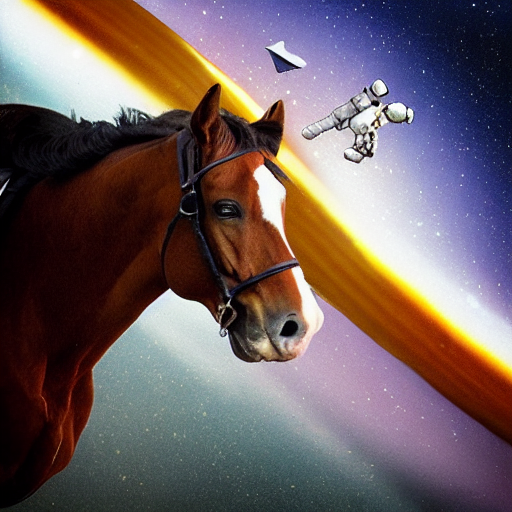

In [13]:
image = (image /2+0.5).clamp(0, 1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images= (image*255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]